In [98]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn 
import pickle
import re
import model.base
from model.base import Transformer
import utils 
from utils import *
import rdkit
from rdkit.Chem import rdDistGeom
import numpy as np
from torch.nn.utils import clip_grad_norm_
import os 
import datetime 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rdkit.rdBase.DisableLog('rdApp.*') # Disable rdkit warnings

In [23]:
dataset = MyDataset('data/chembl24_canon_train.pickle', 40)
train_set, val_set = random_split(dataset, [0.9, 0.1])
train_loader = DataLoader(train_set, batch_size=256)
val_loader = DataLoader(val_set, batch_size=256)
vocab, inv_vocab, max_coor_len, max_token_len = dataset.vocab, dataset.inv_vocab, dataset.max_coor_len, dataset.max_token_len

print(f'Number of data: {len(dataset)}')
print(f'Number of unique tokens: {len(vocab)}')
print(f'Maximum number of tokens: {max_token_len}')
print(f'Maximum number of coordinates: {max_coor_len}')

Error in embedding molecule and will be removed:  O=C(NC1=NC(=O)C2CCCN12)Nc1ccccc1
Error in embedding molecule and will be removed:  COC(=O)NC(=N[N+](=O)[O-])NCC1CCOC1
Error in embedding molecule and will be removed:  CC(=O)NC1=NC=NC2C1=C1CCCN1C2(O)N1CCOCC1
Error in embedding molecule and will be removed:  Cc1ccc(NC(=O)NC2=NC(=O)C3CCCN23)cc1Cl
Error in embedding molecule and will be removed:  Clc1ccc(C2CC3NCC32)cn1
Error in embedding molecule and will be removed:  Cc1ccc(NC(=O)NC2=NC(=O)CN2C)nc1
Error in embedding molecule and will be removed:  Cc1ccc(C)c(NC(=O)NC2=NC(=O)C3CCCN23)c1
Error in embedding molecule and will be removed:  Oc1ccc2cc1-c1cc(ccc1O)CCC(O)CCCC2
Error in embedding molecule and will be removed:  CCCCCCNC(=O)NC1=NC(=O)CN1C
Error in embedding molecule and will be removed:  O=C1CCCCc2ccc(O)c(c2)-c2cc(ccc2O)CC1
Error in embedding molecule and will be removed:  CNC(=O)NC(=N)NCCN=[N+]=[N-]
Error in embedding molecule and will be removed:  N#CC12CCC1C1CCCCC12N1CCSCC1
Error 

In [101]:
model = Transformer(256, 512, 8, 4, 0.5, vocab).to(device)
loss_fn = nn.L1Loss()
optim = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [25]:
for i in range(20) : 
    train_loss, val_loss = 0, 0
    model.train()
    for src, x, y, z, tgt in train_loader : 
        src, x, y, z, tgt = src.to(device), x.to(device), y.to(device), z.to(device), tgt.to(device)
        src_mask = (src != vocab['<PAD>']).unsqueeze(-2) 
        x_mask = get_mask(x.squeeze(-1)[:, :-1])
        y_mask = get_mask(y.squeeze(-1)[:, :-1])
        z_mask = get_mask(z.squeeze(-1)[:, :-1])

        
        out = model(src, x[:, :-1], y[:, :-1], z[:, :-1], src_mask, x_mask, y_mask, z_mask)
        loss = loss_fn(out, tgt[:, 1:, :])
        train_loss += loss.item() 
        loss.backward(), optim.step(), optim.zero_grad(), clip_grad_norm_(model.parameters(), 5)

    model.eval()
    for src, x, y, z, tgt in val_loader : 
        src, x, y, z, tgt = src.to(device), x.to(device), y.to(device), z.to(device), tgt.to(device)
        src_mask = (src != vocab['<PAD>']).unsqueeze(-2) 
        x_mask = get_mask(x.squeeze(-1)[:, :-1])
        y_mask = get_mask(y.squeeze(-1)[:, :-1])
        z_mask = get_mask(z.squeeze(-1)[:, :-1])

        
        out = model(src, x[:, :-1], y[:, :-1], z[:, :-1], src_mask, x_mask, y_mask, z_mask)
        loss = loss_fn(out, tgt[:, 1:, :])
        val_loss += loss.item() 
    print(f'Epoch {i+1} - Train Loss: {train_loss / len(train_loader):.3f} - Val Loss: {val_loss / len(val_loader):.3f}')

Epoch 1 - Train Loss: 0.515 - Val Loss: 0.494
Epoch 2 - Train Loss: 0.444 - Val Loss: 0.539
Epoch 3 - Train Loss: 0.432 - Val Loss: 0.571


KeyboardInterrupt: 

In [4]:
src = get_inference_input('O=Cc1ccc(o1)c1ccc(cc1)S(=O)(=O)N', vocab, max_token_len)
src, src.shape

(tensor([[ 0,  4,  6,  3,  9, 10,  9,  9,  9,  5, 11, 10,  7,  9, 10,  9,  9,  9,
           5,  9,  9, 10,  7, 15,  5,  6,  4,  7,  5,  6,  4,  7, 13,  1]]),
 torch.Size([1, 34]))

In [151]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def inference(model, smi, vocab, max_token_len, plot = False) : 
    num_atom = rdkit.Chem.MolFromSmiles(smi).GetNumAtoms()
    src = get_inference_input(smi, vocab, max_token_len) if type(smi) == str else smi
    model.eval()

    src = src.to(device)
    src_mask = (src != vocab['<PAD>']).unsqueeze(-2)
    x = torch.zeros(1, 1, 1).to(device) 
    y = torch.zeros(1, 1, 1).to(device)
    z = torch.zeros(1, 1, 1).to(device)
    out = torch.zeros(1, 1, 3).to(device)
    
    for _ in range(num_atom - 1)  :
        x_mask = get_mask(x.squeeze(-1))
        y_mask = get_mask(y.squeeze(-1))
        z_mask = get_mask(z.squeeze(-1))
        pred = model(src, x, y, z, src_mask, x_mask, y_mask, z_mask)
        x_pred, y_pred, z_pred = torch.chunk(pred[:, -1, :], 3, dim = -1)
        
        x = torch.cat((x, x_pred.unsqueeze(1)), dim = 1)
        y = torch.cat((y, y_pred.unsqueeze(1)), dim = 1)
        z = torch.cat((z, z_pred.unsqueeze(1)), dim = 1)

        xyz = torch.cat((x_pred, y_pred, z_pred), dim = -1).unsqueeze(1)
        out = torch.cat((out, xyz), dim = 1)

        self_attn = model.encoder.layers[-1].self_attn.attn
        x_attn = model.xdecoder.layers[-1].src_attn.attn
        y_attn = model.ydecoder.layers[-1].src_attn.attn
        z_attn = model.zdecoder.layers[-1].src_attn.attn
    
    if plot : 
        visualize_attn(x_attn, smi, 'x-cross-attn')
        visualize_attn(y_attn, smi, 'y-cross-attn')
        visualize_attn(z_attn, smi, 'z-cross-attn')
        visualize_attn(self_attn, smi, 'self-attn')
    return out
            
def visualize_attn(attn, smi, type) : 
    token_len = len(tokenizer(smi))
    num_atom = attn.size(-2)
    if not os.path.exists(f'attention-inference/{smi}') : 
        os.makedirs(f'attention-inference/{smi}/x-cross-attn')
        os.makedirs(f'attention-inference/{smi}/y-cross-attn')
        os.makedirs(f'attention-inference/{smi}/z-cross-attn')
        os.makedirs(f'attention-inference/{smi}/self-attn')

    attn = attn.squeeze(0)
    if type == 'self-attn' : 
        attn = attn[:, :token_len, :token_len]
    else :
        attn = attn[:, :, :token_len]
    attn = attn.cpu().detach().tolist() 



    figsize = (15, 8) if type == 'self-attn' else (20, 5)
    fig, axs = plt.subplots(2, 4, figsize=figsize)
    axs = axs.flatten()
    for i, mat in enumerate(attn) : 
        axs[i].xaxis.set_ticks_position('top')
        axs[i].imshow(mat, cmap = 'viridis')
        axs[i].set_xticks(np.arange(token_len))
        axs[i].set_yticks(np.arange(token_len)) if type == 'self-attn' else axs[i].set_yticks(np.arange(num_atom))
        axs[i].set_xticklabels(tokenizer(smi))
        axs[i].set_yticklabels(tokenizer(smi)) if type == 'self-attn' else axs[i].set_yticklabels(np.arange(num_atom))

    plt.tight_layout()
    fig.patch.set_facecolor('white')
    plt.savefig(f'attention-inference/{smi}/{type}/{datetime.datetime.now()}.png')
    


FileNotFoundError: [Errno 2] No such file or directory: 'attention-inference/O=Cc1ccc(o1)c1ccc(cc1)S(=O)(=O)N/cross-attn/2024-02-09 17:12:07.540672.png'

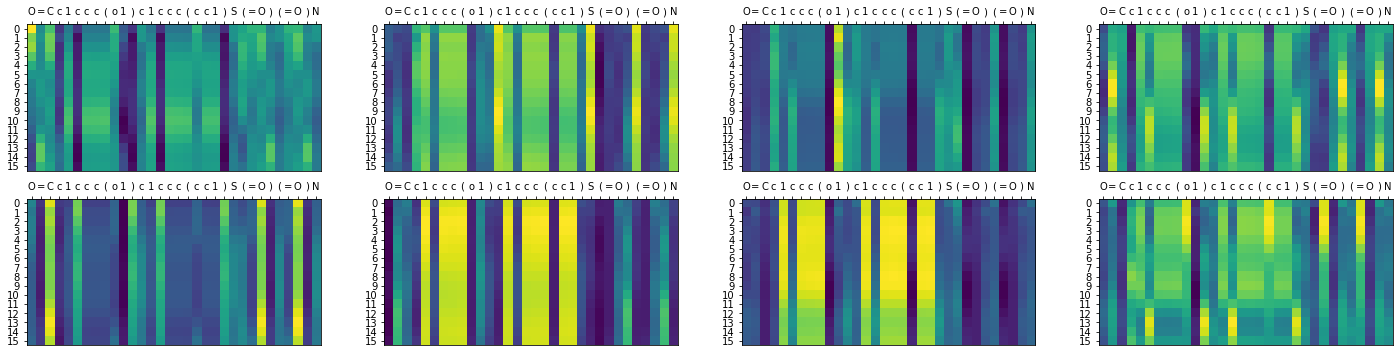

In [152]:
out = inference(model, 'O=Cc1ccc(o1)c1ccc(cc1)S(=O)(=O)N', vocab, max_token_len, plot = True)
